In [1]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd## 데이터 경로 지정d
import os
import cv2

print(tf.__version__)

1.14.0


In [2]:
"""Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR 해결 책."""
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
#gpu 메모리 할당 문제....

## 데이터 경로 지정

In [3]:
base_path = os.path.join('./data')
raw_train_df_path = os.path.join(base_path, 'boneage-training-dataset.csv')
raw_train_df = pd.read_csv(raw_train_df_path)

## CSV파일의 'column' 추가하기

#### 1. ['path'] column 지정
- bone_age.png 파일을 읽어올때 csv파일에 기록되어 있는 label들과 matching을 하기 위해서 추가함.

#### 2. ['gender'] column 지정
- True와 False로 되어있는 것을 Male과 Female로 변경해서 추가

#### 3. ['boneage_category'] column 지정

#### 4. ['male'] column 수정
- True와 False로 되어있어서 histogram을 그릴때 오류가 난다. 따라서 int형으로 1, 0 으로 변경해준다.
#### 5. ['exists'] column 지정.
- 결측값 확인 및 총 데이터 개수 확인하기 위함이다.

In [4]:
raw_train_df.head(5)

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [5]:
raw_train_df['path'] = raw_train_df['id'].map(lambda x: os.path.join(base_path, 'boneage-training-dataset', '{}.png'.format(x)))
raw_train_df['gender'] = raw_train_df['male'].map(lambda x: 'male' if x else 'female')
raw_train_df['male'] =raw_train_df['male'].map(lambda x: 1 if x else 0)
raw_train_df['boneage_category'] = pd.cut(raw_train_df['boneage'], 10)
raw_train_df['exists'] = raw_train_df['path'].map(os.path.exists)
print(raw_train_df['exists'].sum(), 'Image found of', raw_train_df.shape[0], 'total')

12611 Image found of 12611 total


## train & Validation & test Data split

In [6]:
train_df, raw_valid_df = train_test_split(raw_train_df, test_size = 0.3, random_state = 2018, stratify=raw_train_df['boneage_category'])
#stratify=train_df['boneage_category']은, 비율을 유지함.
print('train', train_df.shape[0], 'validation', raw_valid_df.shape[0])

train 8827 validation 3784


In [7]:
valid_df, test_df = train_test_split(raw_valid_df, test_size = 0.3, random_state = 2018, stratify = raw_valid_df['boneage_category'])
print('validation', valid_df.shape[0], 'test', test_df.shape[0])

validation 2648 test 1136


In [8]:
print('엑셀 파일 전체 데이터 셋 : ', raw_train_df.shape[0])
print('train_df 데이터 셋 : ', train_df.shape[0])
print('valid_df의 데이터 셋 : ', valid_df.shape[0])
print('test_df의 데이터 셋 : ', test_df.shape[0])

print(train_df[['boneage', 'male']].shape)


엑셀 파일 전체 데이터 셋 :  12611
train_df 데이터 셋 :  8827
valid_df의 데이터 셋 :  2648
test_df의 데이터 셋 :  1136
(8827, 2)


## Data Groupping
- validation과 test dataset은 group안해줘도 된다.

new data size :  10000 Old Szie : 8827


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3bd41796a0>,
      dtype=object)

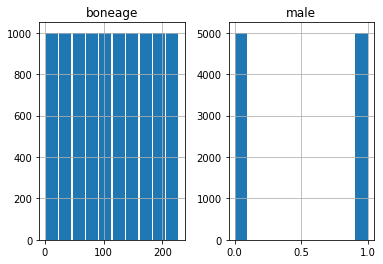

In [9]:
new_train_df = train_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace=True)).reset_index(drop=True)
print("new data size : ", new_train_df.shape[0], 'Old Szie :', train_df.shape[0])
new_train_df[['boneage', 'male']].hist(rwidth=0.9)

## Data numpy 형태로 변환.

In [10]:
train_images_list = []
train_labels_list = []
i = 0
for index, row in new_train_df.iterrows():
    if i%1000 == 0:
        print("Loading %d/10000"%i)
    path = row['path']
    image_array = cv2.imread(path)
    image_array = cv2.resize(image_array, dsize=(150, 150))
    train_images_list.append(image_array)
    train_labels_list.append(row['boneage'])
    #plt.imshow(image_array)
    #plt.show()
    i+=1

Loading 0/10000
Loading 1000/10000
Loading 2000/10000
Loading 3000/10000
Loading 4000/10000
Loading 5000/10000
Loading 6000/10000
Loading 7000/10000
Loading 8000/10000
Loading 9000/10000


In [11]:
valid_images_list = []
valid_labels_list = []
i = 0
for index, row in valid_df.iterrows():
    if i%1000 == 0:
        print("Loading %d/3000"%i)
    path = row['path']
    image_array = cv2.imread(path)
    image_array = cv2.resize(image_array, dsize=(150, 150))
    valid_images_list.append(image_array)
    valid_labels_list.append(row['boneage'])
    i+=1

Loading 0/3000
Loading 1000/3000
Loading 2000/3000


In [12]:
test_images_list = []
test_labels_list = []
i = 0
for index,row in test_df.iterrows():
    if i%1000 == 0:
        print("Loading %d/1500"%i)
    path = row['path']
    image_arary = cv2.imread(path)
    image_arary = cv2.resize(image_arary, dsize=(150, 150))
    test_images_list.append(image_arary)
    test_labels_list.append(row['boneage'])
    i+=1

Loading 0/1500
Loading 1000/1500


In [13]:
train_images, train_labels = np.stack(train_images_list, axis=0), np.stack(train_labels_list, axis=0)
valid_images, valid_labels = np.stack(valid_images_list, axis=0), np.stack(valid_labels_list, axis=0)
test_images, test_labels = np.stack(test_images_list, axis=0), np.stack(test_labels_list, axis=0)

print("train_images shape :", train_images.shape)
print("train_labels shape :", train_labels.shape)
print("valid_images shape :", valid_images.shape)
print("valid_labels shape :", valid_labels.shape)
print("test_images shape :", test_images.shape)
print("test_labels shape :", test_labels.shape)

train_images shape : (10000, 150, 150, 3)
train_labels shape : (10000,)
valid_images shape : (2648, 150, 150, 3)
valid_labels shape : (2648,)
test_images shape : (1136, 150, 150, 3)
test_labels shape : (1136,)


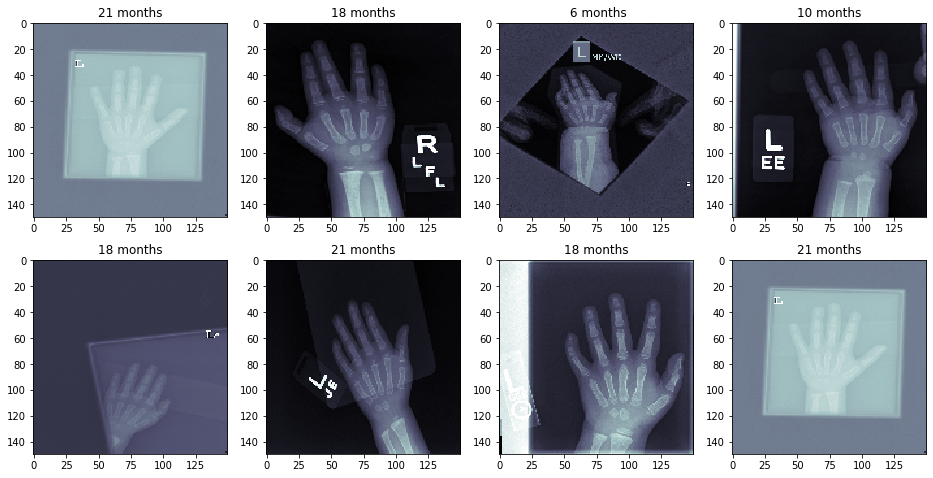

In [14]:
fig, m_axs = plt.subplots(2, 4, figsize=(16, 8))
for(conv_x, conv_y, conv_ax) in zip(train_images, train_labels, m_axs.flatten()):
    conv_ax.imshow(conv_x[:, :, 0], cmap='bone', vmin=0, vmax=254)
    conv_ax.set_title('%2.0f months' % (conv_y))

In [18]:
from tensorflow.keras.metrics import mean_absolute_error
def mae_months(input_true, input_pred):
  return mean_absolute_error(input_true, input_pred)

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, Input, Model

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='linear'))
model.summary()

W0812 16:01:37.606241 139897634228032 deprecation.py:506] From /home/mulkong/anaconda3/envs/mulkong/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2

In [20]:
conv_base.trainable = False #convolutilan layer를 freezing함. --> training하는 동안 weight update를 방지함.

In [21]:
model.compile(loss='mse', optimizer=optimizers.Adam(lr=1e-4), metrics=[mae_months])

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size=10000).batch(32)
validation_dataset = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels)).shuffle(buffer_size = 10000).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(buffer_size = 10000).batch(32)

In [23]:
hist = model.fit(train_dataset, validation_data = validation_dataset, epochs=50)

Epoch 1/50
313/313 [==============================] - 25s 81ms/step - loss: 2926.2891 - mae_months: 40.3801 - val_loss: 1045.6768 - val_mae_months: 24.9369
Epoch 2/50
313/313 [==============================] - 17s 53ms/step - loss: 1386.1974 - mae_months: 28.1026 - val_loss: 1088.9438 - val_mae_months: 25.7317
Epoch 3/50
313/313 [==============================] - 17s 53ms/step - loss: 1137.2934 - mae_months: 25.2166 - val_loss: 1004.2178 - val_mae_months: 24.7174
Epoch 4/50
313/313 [==============================] - 17s 53ms/step - loss: 989.5024 - mae_months: 23.6630 - val_loss: 944.2341 - val_mae_months: 23.9849
Epoch 5/50
313/313 [==============================] - 17s 53ms/step - loss: 872.5147 - mae_months: 22.1823 - val_loss: 910.4983 - val_mae_months: 23.7563
Epoch 6/50
313/313 [==============================] - 17s 53ms/step - loss: 834.2774 - mae_months: 21.6200 - val_loss: 855.0147 - val_mae_months: 23.0013
Epoch 7/50
313/313 [==============================] - 17s 53ms/step - 

In [24]:
model.save('boneage_VGG16.h5')

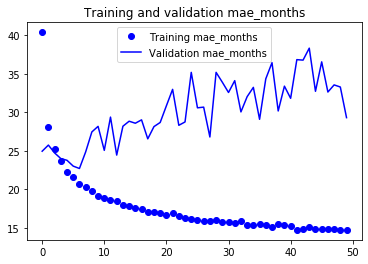

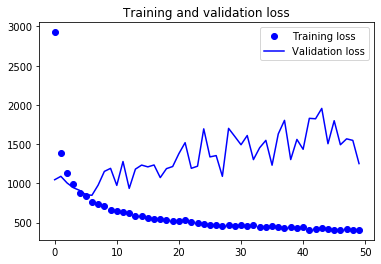

In [25]:
mae_months = hist.history['mae_months']
val_mae_months = hist.history['val_mae_months']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(len(mae_months))

plt.plot(epochs, mae_months, 'bo', label='Training mae_months')
plt.plot(epochs, val_mae_months, 'b', label='Validation mae_months')
plt.title('Training and validation mae_months')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [26]:
pred_Y = model.predict(test_images, batch_size = 32, verbose = True)
test_Y_months = test_labels

1136/1136 [==============================] - 3s 3ms/sample


Text(0, 0.5, 'Predicted Age (Months)')

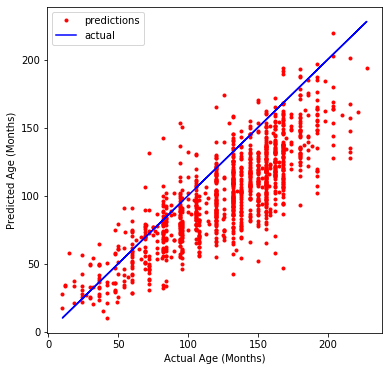

In [27]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

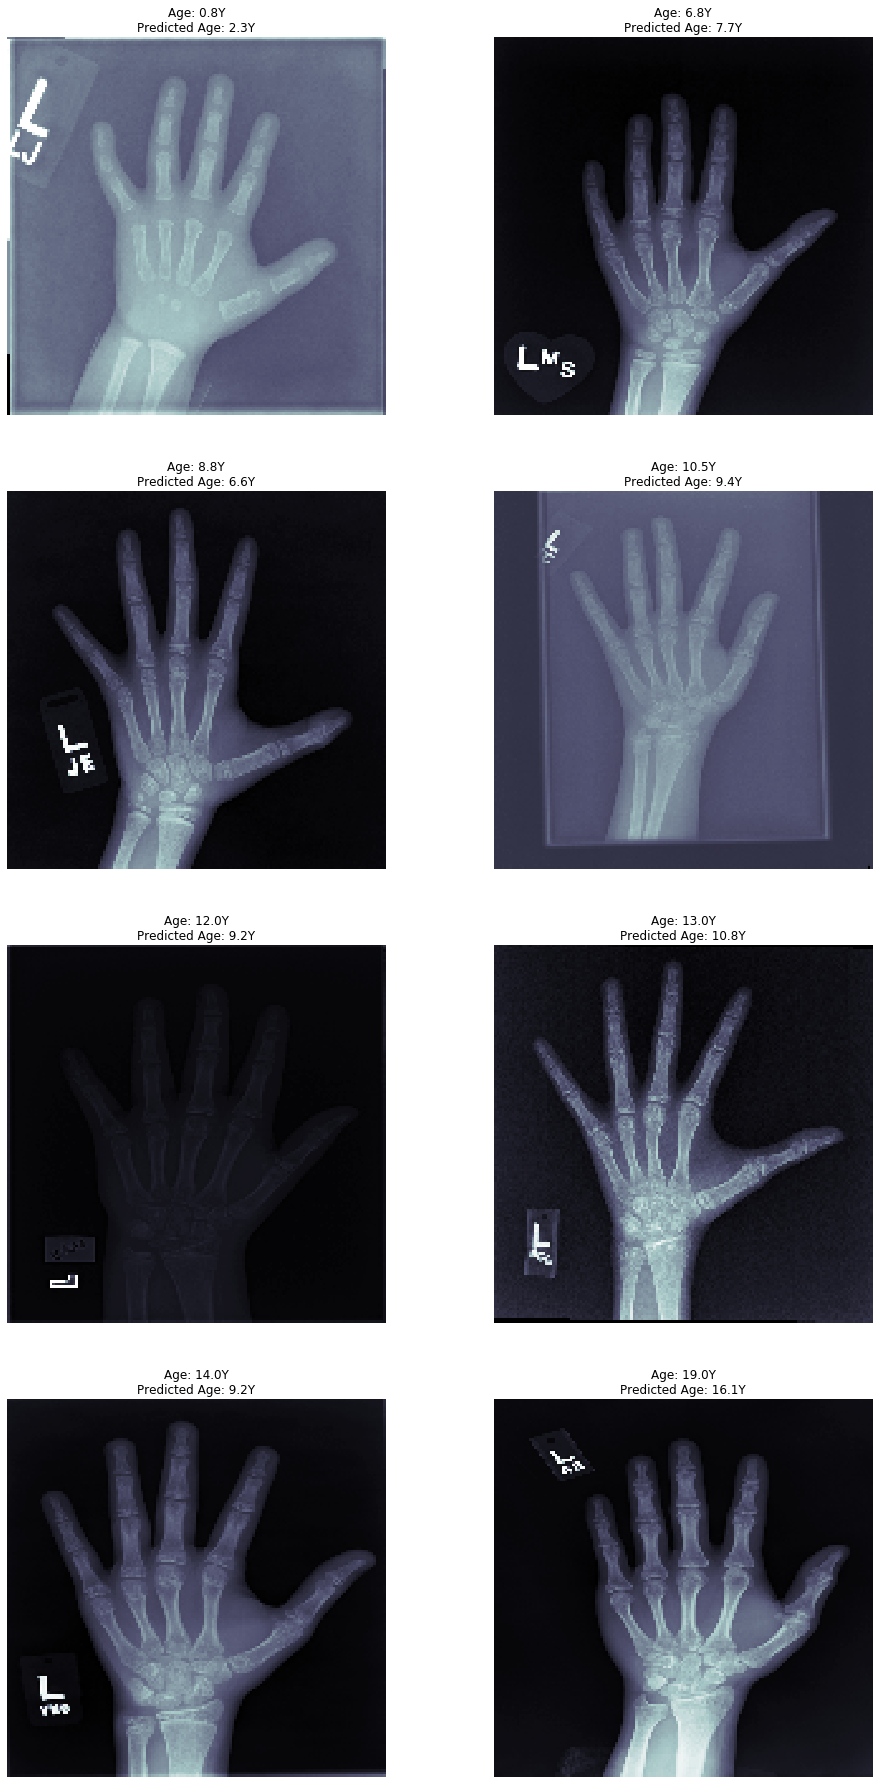

In [28]:
ord_idx = np.argsort(test_labels)
ord_idx = ord_idx[np.linspace(0, len(ord_idx)-1, 8).astype(int)] # take 8 evenly spaced ones
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(ord_idx, m_axs.flatten()):
    c_ax.imshow(test_images[idx, :,:,0], cmap = 'bone')
    
    c_ax.set_title('Age: %2.1fY\nPredicted Age: %2.1fY' % (test_Y_months[idx]/12.0, 
                                                           pred_Y[idx]/12.0))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)

In [29]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1227.4109436894807
Test accuracy: 29.001434
